In [1]:
import os 
from google.colab import drive 
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/BME548_FinalProject")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BME548_FinalProject


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 26 21:02:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 50:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocess Data

In [5]:
def get_file_list (filePath):
    fileList = []
    for onefile in glob.glob(filePath):
        fileList.append(onefile)
    return fileList

def loadData (fileList):
    data = []
    for onefile in fileList:
        data.append(cv2.imread(onefile, cv2.IMREAD_GRAYSCALE))
    return data

In [6]:
datafileList = get_file_list("archive/frames/*.png")
labelfileList = []
for item in datafileList:
    labelfileList.append(item.replace('frames', 'masks'))

In [7]:
frames = loadData(datafileList)

In [8]:
masks = loadData(labelfileList)

In [9]:
X = np.array(frames)
y = (np.stack(masks, axis=0) / 255.0).astype(int)
print(X.shape)
print(y.shape)

(2729, 512, 512)
(2729, 512, 512)


In [10]:
# plt.imshow(X[0], cmap = "gray");

In [11]:
# plt.imshow(y[0], cmap = "gray");

In [12]:
# #hardcode quantization 2
# X = np.floor(X/2) * 2

In [13]:
# #hardcode quantization 4
# X = np.floor(X/4) * 4

In [14]:
# #hardcode quantization 8
# X = np.floor(X/8) * 8

In [15]:
# #hardcode quantization 16
# X = np.floor(X/16) * 16

In [16]:
# #hardcode quantization 32
# X = np.floor(X/32) * 32

In [17]:
# #hardcode quantization 64
# X = np.floor(X/64) * 64

In [18]:
# #hardcode quantization 128
# X = np.floor(X/128) * 128

In [19]:
# print(np.unique(X))

In [20]:
all_indices = np.arange(0, X.shape[0])
np.random.seed(1)
np.random.shuffle(all_indices)
TEST_FRAC = 0.2 
test_indices  = all_indices[0:int(X.shape[0] * TEST_FRAC)]
train_indices = all_indices[int(X.shape[0] * TEST_FRAC):]
X_train = X[train_indices]
X_test  = X[test_indices]
y_train = y[train_indices]
y_test  = y[test_indices]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2184, 512, 512)
(2184, 512, 512)
(545, 512, 512)
(545, 512, 512)


In [21]:
############################################################################

### Prepare Baseline U-Net Model

In [22]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 
def dice_loss (y_true, y_pred) :
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1 
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_pred_flat * y_true_flat)
    dice_coef = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return 1 - dice_coef

def segment_loss (y_true, y_pred) :
    # Segment Loss = Dice Loss + Binary Cross Entropy Loss
    seg_loss = dice_loss(y_true, y_pred) + binary_crossentropy(y_true, y_pred) 
    return seg_loss 

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint = "UNET_DICE_BCE.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV2.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV4.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV8.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV16.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV32.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV64.h5"
# model_checkpoint = "UNET_DICE_BCE_DIV128.h5"

# model_checkpoint = "Quantize_128.h5"
model_checkpoint = "Quantize_128_ClipWeights.h5"
# model_checkpoint = "Quantize_Test.h5"

checkpoint_callback = ModelCheckpoint(filepath = model_checkpoint, 
                                      monitor = "val_loss",  
                                      save_best_only = True, 
                                      # save_weights_only = False, 
                                      save_weights_only = True, 
                                      mode = "min", 
                                      verbose = 1)

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler (epoch, lr) :
    if epoch < 30 :
        return lr 
    else :
        return lr * tf.math.exp(-0.1)
lr_callback = LearningRateScheduler(schedule = scheduler, 
                                    verbose = 1)

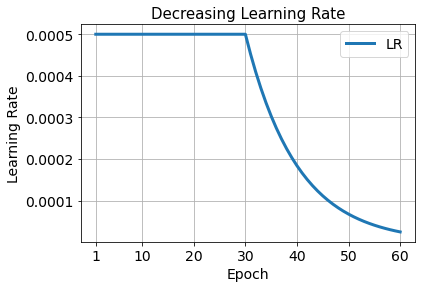

In [25]:
arr_lr = np.zeros(60)
arr_lr[0] = 0.0005
for i in range(59) :
    arr_lr[i+1] = scheduler(epoch = i+1, lr = arr_lr[i])
figure, axis = plt.subplots()
xaxis_epoch = np.linspace(1, 60, num = 60).astype(int)
axis.plot(xaxis_epoch, arr_lr, label = "LR", linewidth = 3)
axis.set_xlabel("Epoch", fontsize = 14)
axis.set_ylabel("Learning Rate", fontsize = 14)
axis.set_title("Decreasing Learning Rate", fontsize = 15)
axis.grid()
figure.set_size_inches(6, 4)
xaxis_ticks = np.array([1, 10, 20, 30, 40, 50, 60]).astype(int)
plt.xticks(xaxis_ticks, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = "best", fontsize = 14)
plt.show()

In [26]:
# import tensorflow_probability as tfp
# # import norm
# from keras.constraints import max_norm
# class quantization_layer(tf.keras.layers.Layer):
#     def __init__(self, is_train=True):
#         super(quantization_layer, self).__init__()
#         self.trainable = is_train

#     def build(self, input_shape):

#         weight_init = tf.ones_initializer()
#         self.W = tf.Variable(initial_value=weight_init(shape=[input_shape[1], 
#                                                               input_shape[2], 1]), 
#                              trainable=True, dtype='float32', 
#                              constraint = lambda w: tf.clip_by_value(w, 
#                                                                      clip_value_min=0.6, 
#                                                                      clip_value_max=0.8))

#     def get_temp(self):
#         temperature = 1.0
#         dist = tfp.distributions.RelaxedBernoulli(temperature, logits=self.W*10)
#         soft_choice = dist.sample()
#         hard_choice = tf.round(soft_choice)
#         choices = tf.stop_gradient(hard_choice - soft_choice) + soft_choice
#         return choices
    
#     def call(self, inputs):
#         choices = self.get_temp()
#         outputs = inputs//(choices*127+1) * (choices*127+1)
#         return outputs

In [27]:
import tensorflow_probability as tfp
# import norm
from keras.constraints import max_norm
from keras import backend

# half_L1 = 512 * 512 //2
class L1Norm(tf.keras.constraints.Constraint):
    def __init__(self, desired=131072, min_value=131072, max_value=131072):
      self.min_value = min_value
      self.max_value = max_value
      self.desired = desired
      
    def __call__(self, w):
      w = backend.clip(w, 0, 1.5)
      norms = tf.reduce_sum(w, keepdims=True)

      if self.desired:
        desired = self.desired
      else:
        desired = backend.clip(norms, self.min_value, self.max_value)

      w = w * (desired / (backend.epsilon() + norms))
      w = backend.clip(w, 0.0001, 1-0.0001)
      return w


class L1Norm_Logits(tf.keras.constraints.Constraint):
    def __init__(self, desired=131072, min_value=131072, max_value=131072):
      self.min_value = min_value
      self.max_value = max_value
      self.desired = desired
    def __call__(self, w):
      probs = tf.sigmoid(10*w)
      norms = tf.reduce_sum(probs, keepdims=True)
      if self.desired:
        desired = self.desired
      else:
        desired = backend.clip(norms, self.min_value, self.max_value)
      probs = probs * (desired / (backend.epsilon() + norms))
      w = -tf.math.log(1/probs - 1)/10
      return w


# TEST CASE FOR LOGITS CONSTRAINTS

# weight_init = np.full((512, 512, 1), 0.1)
#         # weight_init = 0.8
# wTest = tf.Variable(initial_value=weight_init, trainable=True, constraint=L1Norm_Logits(), dtype='float32')
# wRes = L1Norm_Logits(131072, 131072).__call__(wTest)

# print('wRes', wRes)
# print('wTest: ', wTest)
# print('Sigmoid wRes: ', tf.sigmoid(10*wRes))


class quantization_layer(tf.keras.layers.Layer):
    def __init__(self, is_train=True):
        super(quantization_layer, self).__init__()
        self.trainable = is_train

    def build(self, input_shape):

        # Initialization for logits

        # weight_init = tf.zeros_initializer()
        # self.W = tf.Variable(initial_value=weight_init(shape=[input_shape[1], input_shape[2], 1]), trainable=True, constraint=L1Norm_Logits(), dtype='float32')

        # Initialization for probs

        weight_init = np.full((input_shape[1], input_shape[2], 1), 0.5)
        self.W = tf.Variable(initial_value=weight_init, trainable=True, constraint=L1Norm(), dtype='float32')



    def get_temp(self):
        temperature = 1.0

        # Set logits

        # dist = tfp.distributions.RelaxedBernoulli(temperature, logits=self.W*10)

        # Set probs

        dist = tfp.distributions.RelaxedBernoulli(temperature, probs=self.W)

        soft_choice = dist.sample()
        hard_choice = tf.round(soft_choice)
        choices = tf.stop_gradient(hard_choice - soft_choice) + soft_choice

        # print(choices)
        # for i in range(512):
        #   print(choices[i, :, 0])
        return choices
    
    def call(self, inputs):
        choices = self.get_temp()
        # outputs = tf.multiply(tf.math.floordiv(inputs, 128**choices), 128**choices)
        outputs = inputs//(choices*127+1) * (choices*127+1)

        return outputs

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D
import tensorflow as tf
def create_unet(input_shape, num_classes, add_quantization_layer = True):
    input_layer = Input(input_shape)
    x = input_layer
    ####################################################
    # Add quantization layer
    if add_quantization_layer == True : 
        x = quantization_layer()(x)
    ####################################################
    # down path
    start_filters = 8
    skip_layers = []
    padding = "same"
    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding=padding, activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding=padding, activation='relu')(x)
        skip_layers.append(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding=padding, activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    # up path
    for i in range(3):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(1, 1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [29]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model = create_unet([512, 512, 1], 2)
# model.compile(optimizer = Adam(learning_rate=0.0005), 
#               loss = SparseCategoricalCrossentropy())
model.compile(optimizer = Adam(learning_rate=0.0005), 
              loss = segment_loss)
# model.summary()

In [30]:
# model.summary()

In [31]:
# bad_predictions = model.predict(X_test)

In [32]:
# print(bad_predictions.shape)

In [33]:
##########################################################################################

### Train Baseline U-Net Model
#### Note: The U-Net model has been trained and saved

In [ ]:
history = model.fit(x = X_train, y = y_train, 
                    epochs = 60, 
                    validation_data = (X_test, y_test), 
                    callbacks = [checkpoint_callback, lr_callback])

In [ ]:
# testw = model.layers[1].weights
# print(testw[0].shape)
# print(np.min(testw[0]))

In [ ]:
##########################################################################################

### Evaluate Trained U-Net Model

In [34]:
import warnings
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

In [35]:
def quantize_layerout (X, model) :
    layerout = [layer.output for layer in model.layers[0:3]]
    actmodel = models.Model(inputs = model.input, outputs = layerout)
    acts = actmodel.predict(X)
    layer1out = acts[1]
    return layer1out

In [36]:
model_tr1 = create_unet([512, 512, 1], 2, add_quantization_layer = False)
model_tr2 = create_unet([512, 512, 1], 2, add_quantization_layer = True)
model_tr3 = create_unet([512, 512, 1], 2, add_quantization_layer = False)
model_tr4 = create_unet([512, 512, 1], 2, add_quantization_layer = True)
model_tr1.load_weights("Compare.h5")
model_tr2.load_weights("quantize_probs.h5")
# model_tr2.load_weights("quantize_probs_05_1000.h5")
model_tr3.load_weights("Compare_08_random.h5")
model_tr4.load_weights("quantize_probs_08.h5")

In [37]:
import random 
def random_quantize (X, p = 0.5) :
    sample_array = np.ones((262144, 1))
    sample_array[0:int(262144*p), 0] = 128 
    np.random.seed(1)
    np.random.shuffle(sample_array)
    sample = np.reshape(sample_array, (512, 512))
    X_quantize = X // sample * sample
    return X_quantize

In [38]:
# X_test_quantize = random_quantize(X_test)
# plt.imshow(X_test_quantize[0], cmap = "gray");

In [39]:
# testw = quantize_layerout(X_test[0:3], model_tr2)
# print(testw.shape)

In [40]:
def physical_layer_summary (X, y, model, qmodel, prob = 0.5) :
    plt.figure(figsize = (16, 16))
    titlesize = 14
    for i in range(6) :
        plt.subplot(2, 3, i+1)
        if i == 0 :
            plt.imshow(X[0], cmap = "gray")
            plt.axis("off")
            plt.title("Original Image (8 Bits Left)", fontsize = titlesize)
        if i == 1 :
            X_rq = random_quantize(X, p = prob)
            plt.imshow(X_rq[0], cmap = "gray")
            plt.axis("off")
            plt.title("Randomly Hardcoded Quantization (p = %.1f)" % prob, fontsize = titlesize)
        if i == 2:
            X_q = quantize_layerout(X, qmodel)
            plt.imshow(X_q[0,:,:,0], cmap = "gray")
            plt.axis("off")
            plt.title("Trainable Quantization (p = %.1f)" % prob, fontsize = titlesize)
        if i == 3 :
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(y[0], alpha = 0.5)
            plt.axis("off")
            plt.title("Ground Truth", fontsize = titlesize)
        if i == 4 :
            X_rq = random_quantize(X, p = prob)
            pred_masks = model.predict(X_rq)
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(pred_masks[0,:,:,0], alpha=0.5, vmin=0, vmax=1)
            plt.axis("off")
            plt.title("Randomly Hardcoded Quantization (p = %.1f)" % prob, fontsize = titlesize)
        if i == 5:
            pred_masks = qmodel.predict(X)
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(pred_masks[0,:,:,0], alpha=0.5, vmin=0, vmax=1)
            plt.axis("off")
            plt.title("Trainable Quantization (p = %.1f)" % prob, fontsize = titlesize)
    plt.show()
    return None

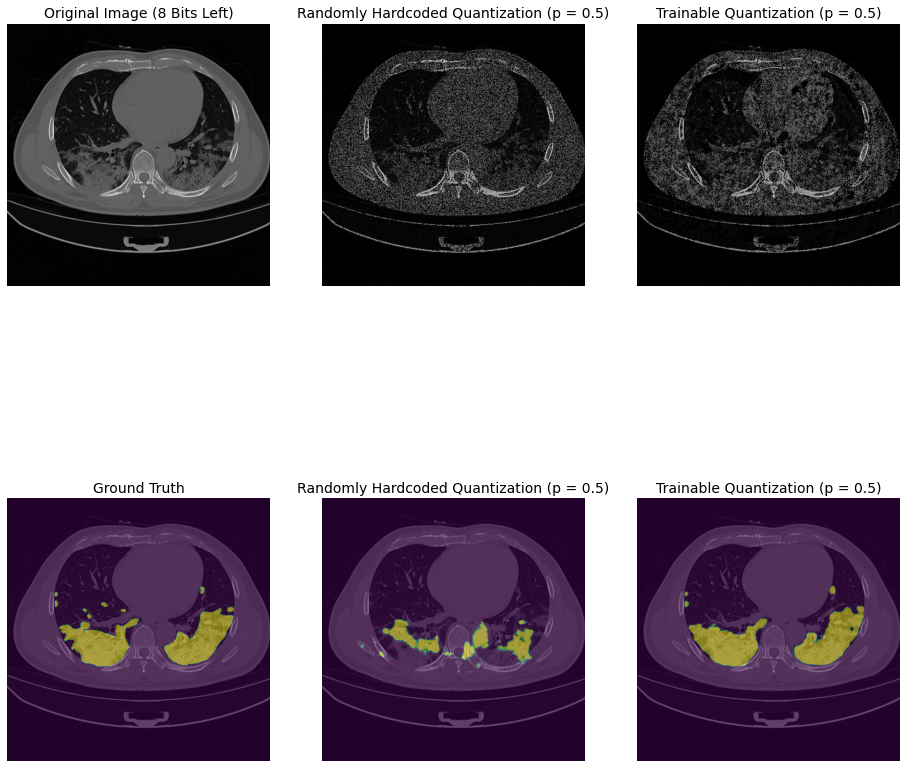

In [41]:
physical_layer_summary(X_test[0:3], y_test[0:3], model_tr1, model_tr2, prob = 0.5)

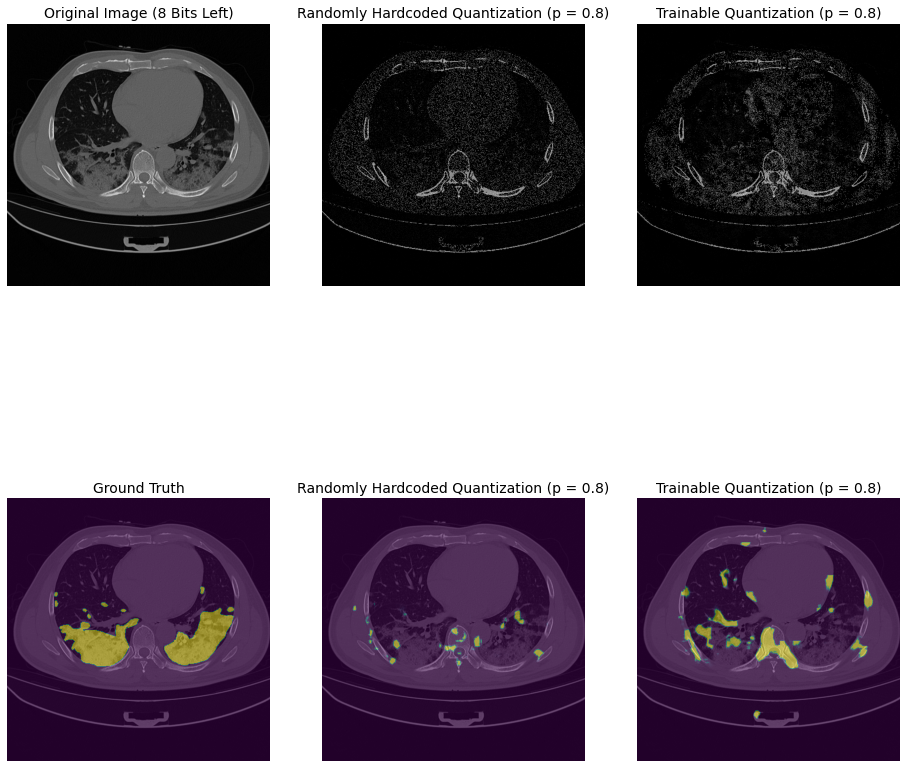

In [42]:
physical_layer_summary(X_test[0:3], y_test[0:3], model_tr3, model_tr4, prob = 0.8)

In [43]:
# layerout = [layer.output for layer in model_tr.layers[0:3]]
# actmodel = models.Model(inputs = model_tr.input, outputs = layerout)
# acts = actmodel.predict(X_test)
# layer1out = acts[0]
# layer2out = acts[1]
# print(layer1out.shape)
# print(layer2out.shape)

In [44]:
# print(np.unique(layer2out[30]))

In [45]:
# X_test_128 = quantize_image(X_test, q = 128)
# print(X_test_128.shape)

In [ ]:
from tensorflow.keras.models import load_model 
model1= load_model("UNET_DICE_BCE.h5", compile = False)
model2 = load_model("UNET_DICE_BCE_DIV2.h5", compile = False)
model4 = load_model("UNET_DICE_BCE_DIV4.h5", compile = False)
model8 = load_model("UNET_DICE_BCE_DIV8.h5", compile = False)
model16 = load_model("UNET_DICE_BCE_DIV16.h5", compile = False)
model32 = load_model("UNET_DICE_BCE_DIV32.h5", compile = False)
model64 = load_model("UNET_DICE_BCE_DIV64.h5", compile = False)
model128 = load_model("UNET_DICE_BCE_DIV128.h5", compile = False)
list_models = [model1,  model2,  model4,  model8,
               model16, model32, model64, model128]
list_models_BAD = [model1, model1, model1, model1, 
                   model1, model1, model1, model1]

In [46]:
def quantize_image (X, q) :
    quantized_X = np.floor(X / q) * q 
    return quantized_X

In [47]:
def interpret_results (preds, active = "sigmoid") :
    out = np.zeros((preds.shape[0], 512, 512))
    if active == "softmax" :
        out[preds[:,:,:,1] > preds[:,:,:,0]] = 1
    if active == "sigmoid" :
        out[preds[:,:,:,0] >= 0.5] = 1
    return out 

In [48]:
def compare_quantization (X) :
    arr_q = np.array([1, 1, 2, 4, 8, 16, 32, 64, 128])
    qbits = np.array([0, 0, 1, 2, 3, 4, 5, 6, 7])
    lbits = np.array([8, 8, 7, 6, 5, 4, 3, 2, 1])
    plt.figure(figsize = (18, 18))
    for i in range(9) :
        plt.subplot(3, 3, i+1) 
        plt.imshow(quantize_image(X, q = arr_q[i]), cmap = "gray")
        plt.axis("off")
        if i == 0 :
            plt.title("Original Image (8 Bits Left)", fontsize = 18)
        elif i == 1 :
            plt.title("No Quantization (8 Bits Left)", fontsize = 18)
        else :
            plt.title("Quantize "+str(qbits[i])+" Bits ("+str(lbits[i])+" Bits Left)", fontsize = 18)
    plt.show()
    return None

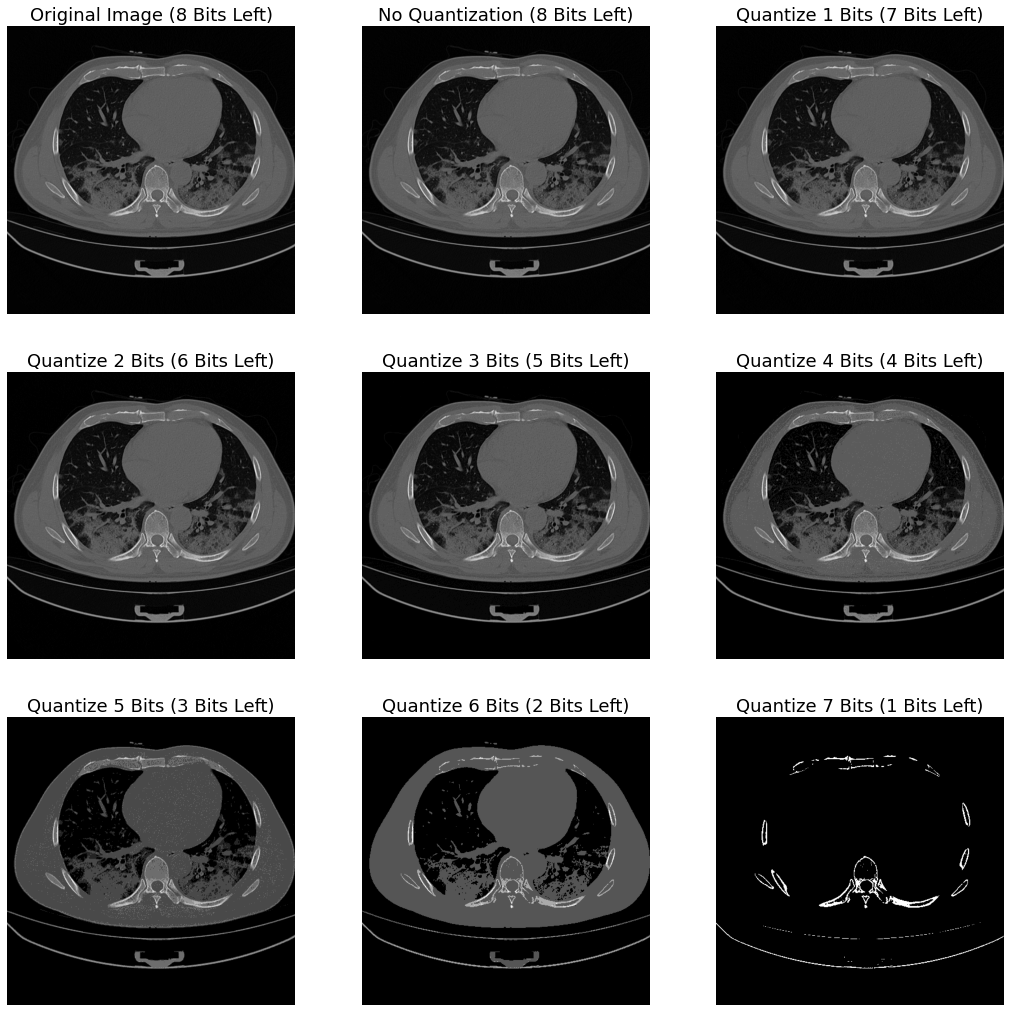

In [ ]:
compare_quantization(X_test[0])

In [49]:
def compare_segmentation (X, y, list_models) :
    arr_q = np.array([1, 1, 2, 4, 8, 16, 32, 64, 128])
    qbits = np.array([0, 0, 1, 2, 3, 4, 5, 6, 7])
    lbits = np.array([8, 8, 7, 6, 5, 4, 3, 2, 1])
    plt.figure(figsize = (18, 18))
    for i in range(9) :
        plt.subplot(3, 3, i+1)
        if i == 0 :
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(y[0], alpha = 0.5)
            plt.title("Ground Truth", fontsize = 18)
            plt.axis("off")
        else :
            model = list_models[i-1]
            # pred_masks = model.predict(X)
            pred_masks = model.predict(quantize_image(X, q = arr_q[i]))
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(pred_masks[0,:,:,0], alpha=0.5, vmin=0, vmax=1)
            if i == 1 :
                plt.title("No Quantization (8 Bits Left)", fontsize = 18)
            else :
                plt.title("Quantize "+str(qbits[i])+" Bits ("+str(lbits[i])+" Bits Left)", fontsize = 18)
            plt.axis("off")
    plt.show()
    return None

In [50]:
def compare_segment_trainable (X, y, list_models) :
    plt.figure(figsize = (18, 18))
    for i in range(len(list_models)+1) :
        plt.subplot(1, len(list_models)+1, i+1)
        if i == 0 :
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(y[0], alpha = 0.5)
            plt.title("Ground Truth", fontsize = 18)
            plt.axis("off")
        else :
            model = list_models[i-1]
            pred_masks = model.predict(X)
            plt.imshow(X[0], cmap = plt.cm.gray)
            plt.imshow(pred_masks[0,:,:,0], alpha=0.5, vmin=0, vmax=1)
            plt.title("Trainable Quantization Layer", fontsize = 18)
            plt.axis("off")
    plt.show()
    return None

In [51]:
#compare_segment_trainable(X_test[0:3], y_test[0:3], [model_tr1, model_tr2])

In [52]:
##########################################################################################

In [ ]:
##########################################################################################

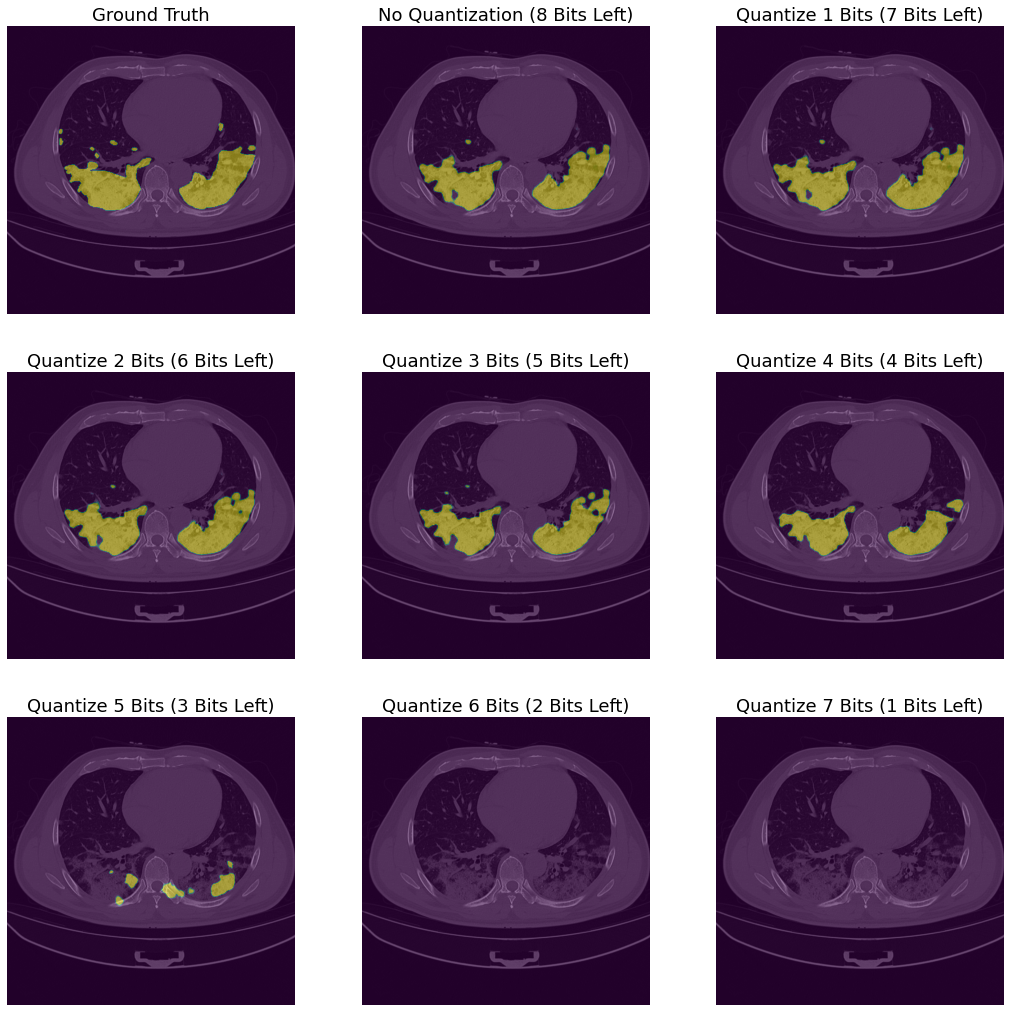

In [ ]:
# Before hard-coded quantization training
compare_segmentation(X = X_test[0:3], y = y_test[0:3], list_models = list_models_BAD)

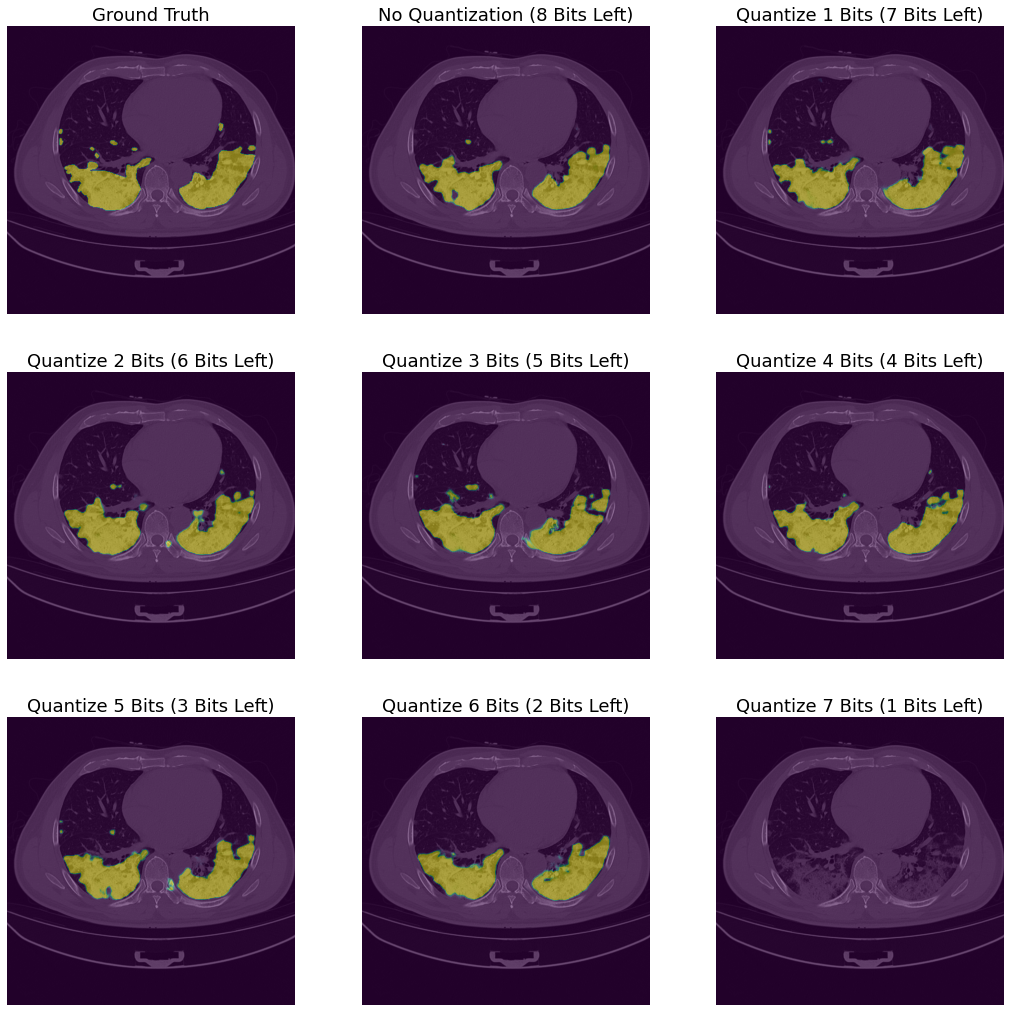

In [ ]:
# After hard-coded quantization training
compare_segmentation(X = X_test[0:3], y = y_test[0:3], list_models = list_models)

In [53]:
##########################################################################################

In [54]:
def calculate_dice_coef (y_true, y_pred) :
    y_preds = interpret_results(y_pred)
    array_true = y_true.flatten()
    array_preds = y_preds.flatten()
    TP = np.sum(np.logical_and(array_preds == 1, array_true == 1)) 
    TN = np.sum(np.logical_and(array_preds == 0, array_true == 0)) 
    FP = np.sum(np.logical_and(array_preds == 1, array_true == 0))
    FN = np.sum(np.logical_and(array_preds == 0, array_true == 1))
    dice = float(2 * TP) / float(2*TP + FN + FP) 
    return dice 

In [55]:
def dice_summary (X, y, list_models) :
    arr_q = np.array([1, 2, 4, 8, 16, 32, 64, 128])
    qbits = np.array([0, 1, 2, 3, 4, 5, 6, 7])
    lbits = np.array([8, 7, 6, 5, 4, 3, 2, 1])
    arr_dice = np.zeros(8)
    for i in range(len(list_models)) :
        model = list_models[i] 
        y_pred = model.predict(quantize_image(X, q = arr_q[i]))
        dice = calculate_dice_coef(y_true = y, y_pred = y_pred) 
        arr_dice[i] = dice 
        print("Quantize",str(qbits[i]),"Bits (",str(lbits[i]),"Bits Left ), Dice Coefficient = %.4f" % dice)
    return arr_dice 

In [56]:
##########################################################################################

In [57]:
dice_tr_test = calculate_dice_coef(y_true = y_test, y_pred = model_tr2.predict(X_test))
print("Trainable Quantization Layer Testing Dice Coeficient = %.4f" % dice_tr_test)

Trainable Quantization Layer Testing Dice Coeficient = 0.8767


In [58]:
dice_tr_test = calculate_dice_coef(y_true = y_test, y_pred = model_tr1.predict(random_quantize(X_test, p = 0.5)))
print("Randomly Hardcoded Quantization Testing Dice Coeficient = %.4f" % dice_tr_test)

Randomly Hardcoded Quantization Testing Dice Coeficient = 0.4925


In [59]:
##########################################################################################

In [60]:
dice_tr_test = calculate_dice_coef(y_true = y_test, y_pred = model_tr4.predict(X_test))
print("Trainable Quantization Layer Testing Dice Coeficient = %.4f" % dice_tr_test)

Trainable Quantization Layer Testing Dice Coeficient = 0.4273


In [61]:
dice_tr_test = calculate_dice_coef(y_true = y_test, y_pred = model_tr3.predict(random_quantize(X_test, p = 0.8)))
print("Randomly Hardcoded Quantization Testing Dice Coeficient = %.4f" % dice_tr_test)

Randomly Hardcoded Quantization Testing Dice Coeficient = 0.4539


In [62]:
# dice_tr_train = calculate_dice_coef(y_true = y_train, y_pred = model_tr.predict(X_train))
# print("Trainable Quantization Layer Training Dice Coefficient = %.4f" % dice_tr_train)

In [61]:
##########################################################################################

In [ ]:
# Before hard-coded quantization training
dice_bad = dice_summary(X_test, y_test, list_models = list_models_BAD)

Quantize 0 Bits ( 8 Bits Left ), Dice Coefficient = 0.8125
Quantize 1 Bits ( 7 Bits Left ), Dice Coefficient = 0.8121
Quantize 2 Bits ( 6 Bits Left ), Dice Coefficient = 0.8090
Quantize 3 Bits ( 5 Bits Left ), Dice Coefficient = 0.7936
Quantize 4 Bits ( 4 Bits Left ), Dice Coefficient = 0.7089
Quantize 5 Bits ( 3 Bits Left ), Dice Coefficient = 0.4873
Quantize 6 Bits ( 2 Bits Left ), Dice Coefficient = 0.1432
Quantize 7 Bits ( 1 Bits Left ), Dice Coefficient = 0.0001


In [ ]:
# After hard-coded quantization training
dice_good = dice_summary(X_test, y_test, list_models = list_models)

Quantize 0 Bits ( 8 Bits Left ), Dice Coefficient = 0.8125
Quantize 1 Bits ( 7 Bits Left ), Dice Coefficient = 0.8087
Quantize 2 Bits ( 6 Bits Left ), Dice Coefficient = 0.8114
Quantize 3 Bits ( 5 Bits Left ), Dice Coefficient = 0.8065
Quantize 4 Bits ( 4 Bits Left ), Dice Coefficient = 0.8064
Quantize 5 Bits ( 3 Bits Left ), Dice Coefficient = 0.7803
Quantize 6 Bits ( 2 Bits Left ), Dice Coefficient = 0.7345
Quantize 7 Bits ( 1 Bits Left ), Dice Coefficient = 0.0000


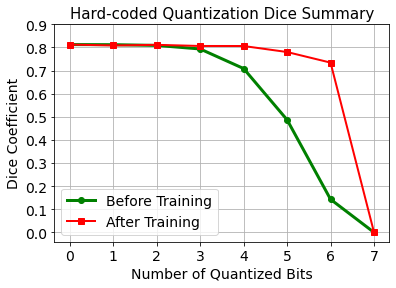

In [ ]:
figure, axis = plt.subplots()
x_axis_bad = np.linspace(0, 7, num = 8).astype(int)
x_axis_good = np.linspace(0, 7, num = 8).astype(int)
axis.plot(x_axis_bad, dice_bad, "g-o", label = "Before Training", linewidth = 3)
axis.plot(x_axis_good, dice_good, "r-s", label = "After Training", linewidth = 2)
axis.set_xlabel("Number of Quantized Bits", fontsize = 14)
axis.set_ylabel("Dice Coefficient", fontsize = 14)
axis.set_title("Hard-coded Quantization Dice Summary", fontsize = 15)
axis.grid()
figure.set_size_inches(6, 4)
plt.xticks(np.linspace(0, 7, num = 8).astype(int), fontsize = 14)
plt.yticks(np.linspace(0, 0.9, num = 10), fontsize = 14)
plt.legend(loc = "best", fontsize = 14)
plt.show()

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
# for i in range(5) :
#     axs[i].imshow(X_test[i], cmap=plt.cm.gray)
#     axs[i].imshow(y_test[i], alpha=0.5)

In [ ]:
# bad_pred = bad_predictions[0] 
# good_pred = good_predictions[0]

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# axs[0].set_title("Untrained model")
# axs[0].imshow(X_test[0], cmap=plt.cm.gray)
# im = axs[0].imshow(bad_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[0])

# axs[1].set_title("Trained model")
# axs[1].imshow(X_test[0], cmap=plt.cm.gray)
# im = axs[1].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[1]);

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# axs[0].set_title("0Trained model")
# axs[0].imshow(X_test[0], cmap=plt.cm.gray)
# im = axs[0].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[0])

# axs[1].set_title("1Trained model")
# axs[1].imshow(X_test[0], cmap=plt.cm.gray)
# im = axs[1].imshow(good_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[1]);

In [ ]:
# y_test_pred = interpret_results(good_predictions, active="sigmoid")

In [ ]:
# plt.imshow(y_test[0], cmap = "gray");

In [ ]:
# plt.imshow(y_test_pred[0], cmap = "gray");